In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import datetime
from group_lasso import GroupLasso
from sklearn.utils import resample, check_random_state
from sklearn.model_selection import cross_val_score, cross_validate

from extra_functions import *

# Silence some warnings
import warnings
warnings.filterwarnings('ignore')

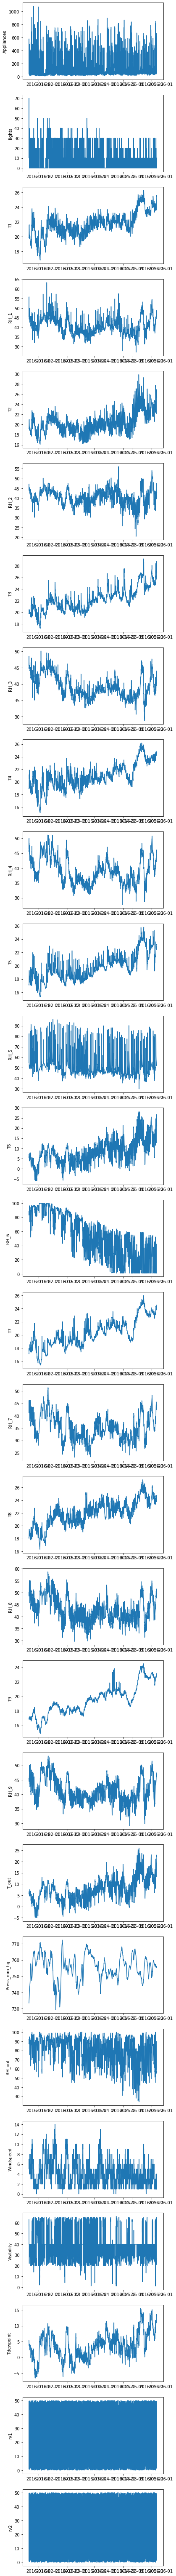

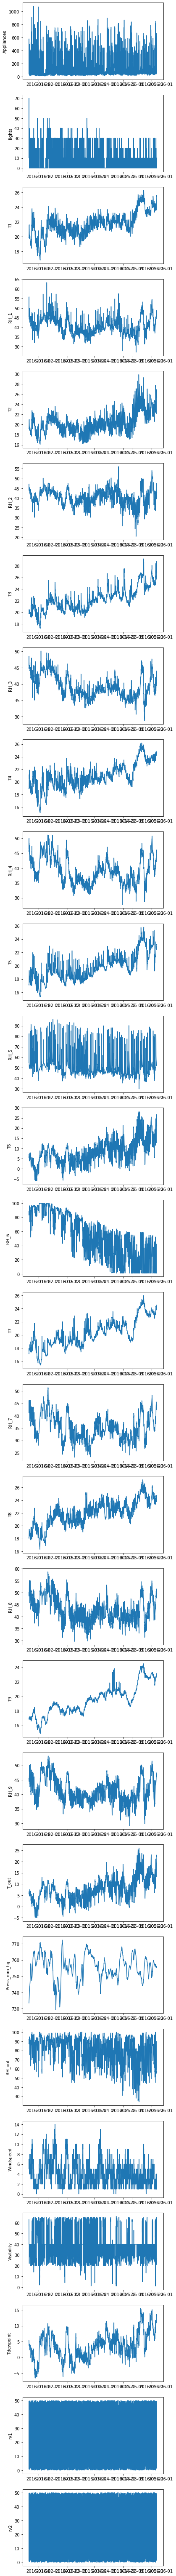

In [2]:
df = pd.read_csv('energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

fig = plot_data(df)
fig

### Generating extra features to describe time
weekday: number [0,6]\
weekstatus: binary describing weekend (1) or not (0)\
NSM: Number of Seconds from Midnight

These are used for filtering the data

In [3]:
weekday = np.zeros(len(df))
weekstatus = np.zeros(len(df))
NSM = np.zeros(len(df))
month = np.zeros(len(df))

for i, val in enumerate(df.index):
    weekday[i] = val.weekday()
    weekstatus[i] = (weekday[i] >= 5)  # False for workday, True for weekend
    NSM[i] = (val - val.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    month[i] = val.month

df['weekday'] = weekday
#df['week status'] = weekstatus
df['NSM'] = NSM
df['month'] = month


## Add n previous timepoints to the data

Here we add the result vector from "t-n" as part of the covariates. 


In [4]:
ns = [1, 6, 144] # Make a list in-case we want to skip some "n"
y = df['Appliances'].values # get y
for n in ns:
    temp = np.zeros_like(y)
    temp[n:] = y[:-n]
    df[f"t-{n}"]=temp
# Strip the first max(n) datapoints that now miss data
n = max(ns)
df = df[n:]

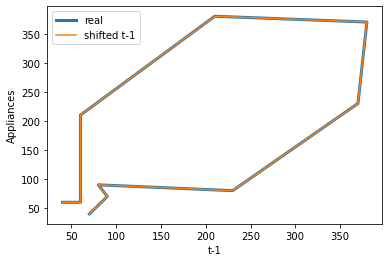

In [5]:
plt.figure()

# These two plots should be identical
plt.plot(df['t-1'][:10],df['Appliances'][:10], lw=3, label="real")
plt.plot(df['t-1'][:10], df['t-1'][1:11], label="shifted t-1") 
plt.xlabel('t-1')
plt.ylabel('Appliances')
plt.legend()
plt.show()

### Filtering data and making training/validation/test set

In [6]:
indices = (np.in1d(df.index.month, (1,2)))

#standardization

#y = np.array(df_train['Appliances']).reshape(-1,1)
#X = np.array(df_train[df_train.columns[1:]])
#X, y = standardize(X,y)

# Train/validation/test

df_train = df[indices]
df_valid = df[(df.index.month==3)]
df_test = df[(df.index.month==4)]

X_train = np.array(df_train[df.columns[df.columns!='Appliances']])
y_train = np.array(df_train[df.columns[df.columns=='Appliances']])
X_test = np.array(df_test[df.columns[df.columns!='Appliances']])
y_test = np.array(df_test[df.columns[df.columns=='Appliances']])
X_valid = np.array(df_valid[df.columns[df.columns!='Appliances']])
y_valid = np.array(df_valid[df.columns[df.columns=='Appliances']])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_valid)
X_valid = scaler.transform(X_valid)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

y_test_mean = y_test.mean()
y_valid_mean = y_valid.mean()
y_train_mean = y_train.mean()

y_train = y_train - y_train_mean
y_valid = y_valid - y_valid_mean
y_test = y_test - y_test_mean

#X_train, y_train = standardize(X_train,y_train)
#X_valid, y_valid = standardize(X_valid,y_valid)
#X_test, y_test = standardize(X_test,y_test)

In [7]:
# Check that the filter was correct
print(len(df[(df.index.month==1)])+ len(df[(df.index.month==2)]))
print(len(df_train))

6954
6954


### Correlations of covariates

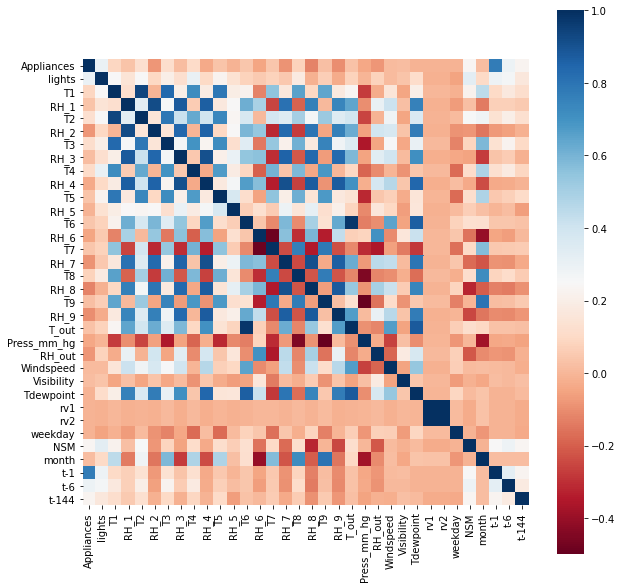

In [8]:
cor = df_train[df_train.columns].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cor, square=True, xticklabels=True, yticklabels=True, cmap='RdBu')
plt.show()

## Neural Networks

### Feedforward Neural Network
The first neural network is actually not a RNN, but a feedforward network, where we include the input features t-n, which denotes the response variable from earlier time steps. 

In [12]:
# Martins code here
import tensorflow as tf
from tensorflow.keras import Sequential, Input, regularizers
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import time
from numpy.random import seed
seed(1)

### Hyper parameter tuning

Hyperparameter tuning of a NN model using either Random Search or Bayesian optimization:

The hyperparameters are:

1. Input layer size
2. Number of layers
3. Size of each layer
4. Regularization term (same for each layer)
5. Learning rate
6. Learning rate decay

The maximum values, minimum values and step size are chosen below in the method ```build_model```


# Next step might take a long time to run!!!

When ```trials = 1000``` the next step took 2 hours and 22 minutes to run.

In [13]:
## Building NN and yuning hyper parameters

# Number of different models tried in the tuning process
trials = 10

# Early stopping
es = EarlyStopping(monitor="val_loss",patience=5)

# Timer
LOG_DIR = f"{int(time.time())}"

def build_model(hp):
    
    # Model
    model = Sequential()
    
    # Building layers
    for i in range(hp.Int('n_layers',min_value=1,max_value=3)):
        model.add(Dense(hp.Int(f"units_{i+1}",min_value=50,max_value=1000,step=50), 
             activation='relu', 
             name=f"dense{i+1}",
             kernel_regularizer=regularizers.l2(hp.Float('l2',1e-6,1)),           
            )
        )
        model.add(Dropout(hp.Float(f"drop_out_rate",0,0.9,0.1),
                         name=f"dropout{i+1}"))
    
    
    model.add(Dense(1,activation='linear', name="outputlayer"))

    # ADAM optimizer, learning rate and decay is specified
    opt = tf.keras.optimizers.Adam(lr=hp.Float('lr',1e-4,1e-3), decay=hp.Float('decay',1e-6,1e-5))

    # The NN is compiled. A MSE loss function is used.
    model.compile(loss='mse',
           optimizer=opt,
           metrics='mse',
           )
    
    return model

## Tuner object
# tuner = RandomSearch(build_model,
#                      objective = 'val_mse',
#                      max_trials = trials,
#                      executions_per_trial = 1,
#                      directory = LOG_DIR
#                     )

tuner = BayesianOptimization(build_model,
                     objective = 'val_mse',
                     max_trials = trials,
                     executions_per_trial = 1,
                     directory = LOG_DIR
                    )

# Tuner search
tuner.search(x=X_train,
             y=y_train,
             epochs = 5,
             validation_data=(X_valid,y_valid))

Trial 10 Complete [00h 00m 04s]
val_mse: 9780.6806640625

Best val_mse So Far: 4494.78564453125
Total elapsed time: 00h 00m 52s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Best selection of hyperparameters found from tuning
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'n_layers': 3,
 'units_1': 700,
 'l2': 0.7143873779140077,
 'drop_out_rate': 0.4,
 'lr': 0.0009861683667958846,
 'decay': 5.551040721570183e-06,
 'units_2': 50,
 'units_3': 50}

In [15]:
# Compiling the model using the best params
model = build_model(best_hp)

# The model is fitted to the training data and validated using the validation data. Variable number of epochs.
history = model.fit(X_train,y_train, epochs=20, verbose=0, validation_data=(X_valid,y_valid), callbacks=es)

# The predicted values are found using the test set
y_pred = model.predict(X_test)

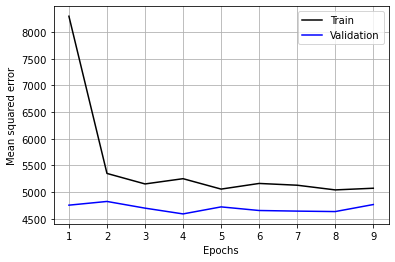

In [16]:
plt.figure()
plt.plot(np.arange(1,len(history.history['mse'])+1),history.history['mse'],'k-',label='Train')
plt.plot(np.arange(1,len(history.history['mse'])+1),history.history['val_mse'],'b-',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid()
plt.legend()
plt.show()

In [17]:
# A summary of the used network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 700)               23800     
_________________________________________________________________
dropout1 (Dropout)           (None, 700)               0         
_________________________________________________________________
dense2 (Dense)               (None, 50)                35050     
_________________________________________________________________
dropout2 (Dropout)           (None, 50)                0         
_________________________________________________________________
dense3 (Dense)               (None, 50)                2550      
_________________________________________________________________
dropout3 (Dropout)           (None, 50)                0         
_________________________________________________________________
outputlayer (Dense)          (None, 1)                

In [18]:
# Function that calculates the R^2 value
def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(( y_true - y_pred )**2)
    SS_tot = np.sum(( y_true - np.mean(y_true) )**2 )
    return ( 1 - SS_res/SS_tot )

# Train and test score given by R^2
print('Train score: '+ str(coeff_determination(y_train,model.predict(X_train))))
print('Test score: '+ str(coeff_determination(y_test,y_pred)))

Train score: 0.645428699480622
Test score: 0.561720747313197


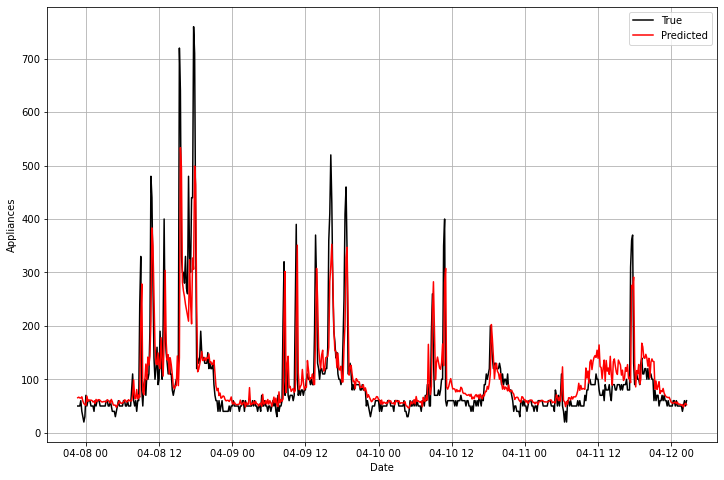

In [19]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 1000
index_last = 1600

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last]+y_test_mean,'k-', label='True')
plt.plot(df_test.index[index_first:index_last],y_pred[index_first:index_last]+y_test_mean,'r-', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

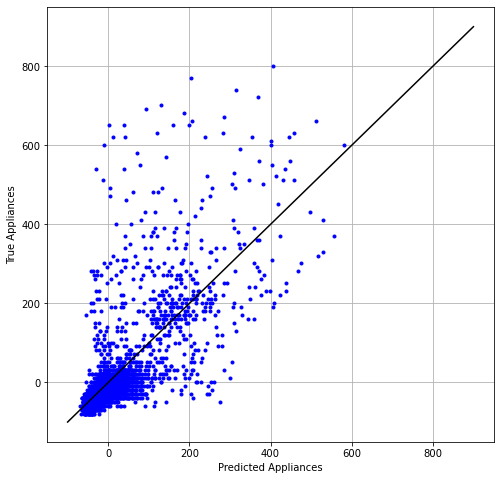

In [20]:
plt.figure(figsize=(8,8))
plt.plot(y_pred,y_test,'b.')
plt.plot([-100,900],[-100,900],'k-')
plt.grid()
plt.xlabel('Predicted Appliances')
plt.ylabel('True Appliances')
plt.show()

### Recurrent Neural Network

In this approach, the last three columns of the input containing information of previous output values are removed. Instead a neural network with recurrent layers is used. These layers takes the hidden state of the last output and feeds to the next input.

In [27]:
# Data preparation
def reshape_lstm(X):
    X_reshaped = X.reshape(X.shape[0],1,X.shape[1])
    return X_reshaped

# Removing the last three columns containing t-n.
X_train_lstm = reshape_lstm(X_train[:,:])
X_test_lstm = reshape_lstm(X_test[:,:])
X_valid_lstm = reshape_lstm(X_valid[:,:])

In [33]:
trials = 10

# Early stopping
es = EarlyStopping(monitor="val_loss",patience=3)

# L2 regularization "lambda"
lmbda = 1e-2

def build_lstm_model(hp):
    # Model
    model = Sequential()
    model.add(LSTM(hp.Int(f"units_{i+1}",min_value=50,max_value=1000,step=50),
                   input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2]),
                   return_sequences=False,
                   activation='relu',
                   kernel_regularizer=regularizers.l2(lmbda),
                   bias_regularizer=regularizers.l2(lmbda)))
    # model.add(Dense(10,
    #                activation='relu',
    #                kernel_regularizer=regularizers.l2(lmbda),
    #                bias_regularizer=regularizers.l2(lmbda)))
    model.add(Dense(1,activation='linear', name="outputlayer"))

    # ADAM optimizer, learning rate and decay is specified
    opt = tf.keras.optimizers.Adam(lr=hp.Float("lr",1e-4,1e-1),
                                   decay=hp.Float("decay",1e-6,1e-3))

    # The NN is compiled. A MSE loss function is used.
    model.compile(loss='mse',
               optimizer=opt,
               metrics='mse')

    return model

tuner = BayesianOptimization(build_lstm_model,
                     objective = 'val_mse',
                     max_trials = trials,
                     executions_per_trial = 1,
                     directory = LOG_DIR
                    )

# Tuner search
tuner.search(x=X_train_lstm,
             y=y_train,
             epochs = 5,
             validation_data=(X_valid,y_valid))

INFO:tensorflow:Reloading Oracle from existing project 1618777558\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from 1618777558\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [29]:
history = model.fit(X_train_lstm, y_train, epochs=100, verbose=0, validation_data=(X_valid_lstm,y_valid), callbacks=es)

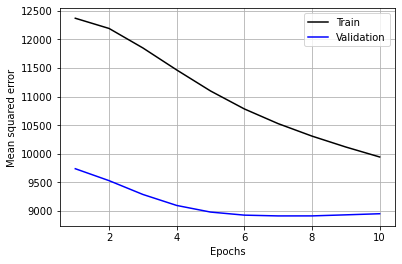

Train score: 0.20542593018223732
Test score: 0.061962312416459775


In [24]:
y_pred = model.predict(X_test_lstm)

plt.figure()
plt.plot(np.arange(1,len(history.history['mse'])+1),history.history['mse'],'k-',label='Train')
plt.plot(np.arange(1,len(history.history['mse'])+1),history.history['val_mse'],'b-',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid()
plt.legend()
plt.show()

# Train and test score given by R^2
print('Train score: '+ str(coeff_determination(y_train,model.predict(X_train_lstm))))
print('Test score: '+ str(coeff_determination(y_test,y_pred)))

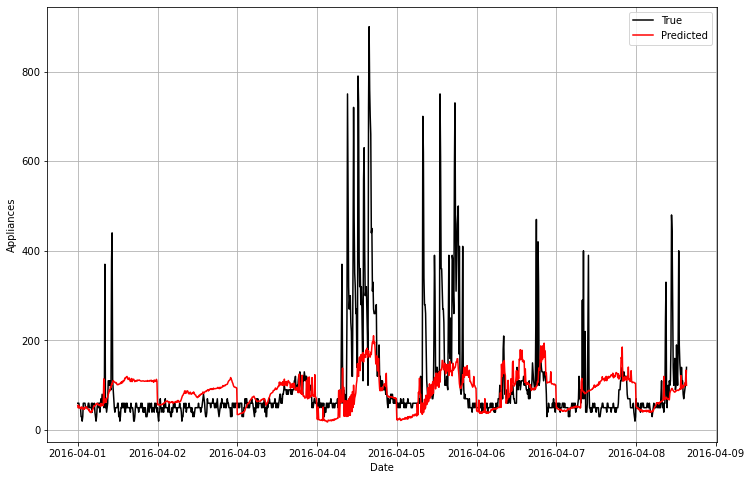

In [25]:
# A plot of real data and predicted data in time between two time intervals:
index_first = 0
index_last = 1100

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last]+y_test_mean,'k-', label='True')
plt.plot(df_test.index[index_first:index_last],y_pred[index_first:index_last]+y_test_mean,'r-', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

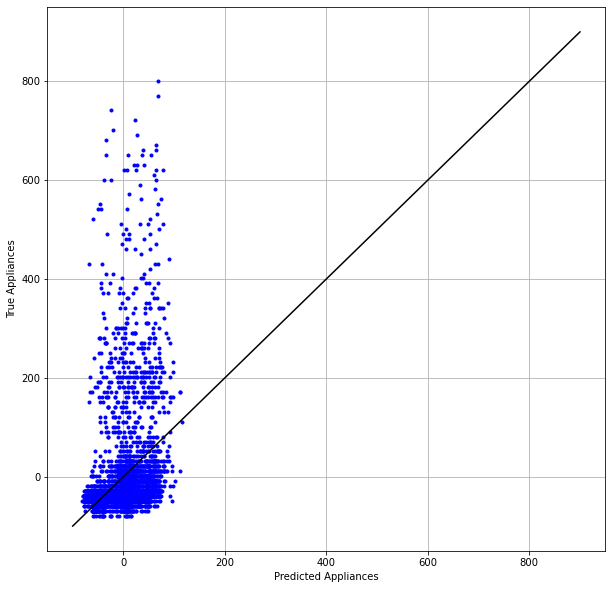

In [26]:
plt.figure(figsize=(10,10))
plt.plot(y_pred,y_test,'b.')
plt.plot([-100,900],[-100,900],'k-')
plt.grid()
plt.xlabel('Predicted Appliances')
plt.ylabel('True Appliances')
plt.show()

## Decision tree surrogacy

Here we are going to investigate what the most important feature is in the trained neural net by training a surrugate model on the output of the NN model. Then we investigate the tree to figure out what features are most important for the NN predictions.

In [ ]:
# Sander's code here

# Retrain the model
# Compiling the model using the best params
model = build_model(best_hp)

# The model is fitted to the training data and validated using the validation data. Variable number of epochs.
_ = model.fit(X_train,y_train, epochs=20, verbose=0, validation_data=(X_valid,y_valid), callbacks=es)


# Set X train to original, but replace Y to the response of the network
s_X_train = X_train
s_Y_train = model.predict(X_train)

s_X_test = X_test
s_Y_test = model.predict(X_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(random_state=42)
clf.fit(s_X_train, s_Y_train)
y_hat_train = clf.predict(s_X_train)
y_hat_test = clf.predict(s_X_test)
train_err = np.average(np.sqrt((y_hat_train-s_Y_train)**2))
test_err = np.average(np.sqrt((y_hat_test-s_Y_test)**2))
print(f"Train MSE: {train_err}")
print(f"Test MSE: {test_err}")

In [ ]:
print(f"Train score: {coeff_determination(s_Y_train, y_hat_train)}")
print(f"Train score: {coeff_determination(s_Y_test, y_hat_test)}")

In [ ]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 1000
index_last = 1600

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],s_Y_test[index_first:index_last]+y_test_mean,'r-', label='NN Predicted')
plt.plot(df_test.index[index_first:index_last],y_hat_test[index_first:index_last]+y_test_mean,'b-', label='surrogate Predicted')
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last]+y_test_mean,'k-', label='True')

plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

In [ ]:
# Here we print the features in order of imporance
feature_importances = clf.tree_.compute_feature_importances()
idx = np.argsort(feature_importances)[::-1]
keys = df.keys()[1:]
for i in idx:
    print(f"{keys[i]}: {feature_importances[i]}")

## Random forrest

In [ ]:
# Youngrong's code her
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## A randomforest model is made. All the ranges of the parameters used for the model are specified.
## Hyperparameters are tunned by gridsearchCV on validation data(Month==3)

model = RandomForestRegressor()

# Range of the gridsearch for RF hyperparameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2)
# Validation with the data to find the best set of hyperparameters
grid_search.fit(X_valid,y_valid.ravel())

In [ ]:
# A summary of the chosen pararmeters
print(grid_search.best_params_)

In [ ]:
# The model is fitted to the training data and validated using the validation data.
rf = model.set_params(**grid_search.best_params_)
rf.fit(X_train, y_train.ravel())

### Load the RF model

In [ ]:
# save the model to disk
import pickle
filename = 'RF_model.sav'
pickle.dump(rf, open(filename, 'wb')
# load the model from disk
#rf = pickle.load(open(filename, 'rb'))

In [ ]:
# The predicted values are found using the test data
y_pred = rf.predict(X_test)

print('Train score: '+ str(coeff_determination(y_train.ravel(),rf.predict(X_train))))
print('Test score: '+ str(coeff_determination(y_test.ravel(),y_pred)))

In [ ]:
# A plot of real data and predicted data in time between two time intervals:

index_first = 500
index_last = 1000

plt.figure(figsize=(12,8))
plt.plot(df_test.index[index_first:index_last],y_test[index_first:index_last],'k-', label='True')
plt.plot(df_test.index[index_first:index_last],y_pred[index_first:index_last],'r-', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(y_pred,y_test,'b.')
plt.plot([0,1000],[0,1000],'k-')
plt.grid()
plt.xlabel('Predicted Appliances')
plt.ylabel('True Appliances')
plt.show()